In [34]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import math
from openpyxl import Workbook

def psy_analytic(x, lamb = -1, case = 1):
    '''
        psy_analytic = np.exp(lamb*x)
    '''
    if case == 1:
        return tf.exp(lamb*x)
    elif case == 2:
        return tf.sin(x)
    elif case == 3:
        return -1 / (1 + x)

def f(x, psy, case = 1):
    if case == 1:
        '''
            d(psy)/dx = f(x, psy)
            y' = B(x) - A(x) * y
        '''
        def A(x, case = 1):
            if case == 1:
                return 1

        def B(x, case = 1):
            if case == 1:
                return 0

        return B(x) - A(x)*psy
    
    elif case == 2:
        '''
            Prothero Robinson
            y' 
        '''
        return -(psy - tf.sin(x)) + tf.cos(x)

    elif case == 3:
        return psy**2

def y(x, w, case = 1): 
    '''
        y(x) = bias + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    if case == 1:
        bias = 1.
    elif case == 2:
        bias = 0.
    elif case == 3:
        bias = -1.

    y = bias
    w_v = w.variables[0]
    n = w_v.shape[0]
    for i in range(1, n+1):
        y += w_v[i-1]*x**i
    
    return y

def y_loss(x, w, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형
    
    with tf.GradientTape() as tape:
        tape.watch(x)

        _y = y(x, w, case = case)
        d_y = tape.gradient(_y, x)
    
    _loss = d_y - f(x, _y, case)
    square_loss = tf.square(_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def y_EC_loss(x, w, NN, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형

    with tf.GradientTape() as tape:
        tape.watch(x)

        y_EC = tf.add(y(x, w, case), NN(x)*x)
        d_y_EC = tape.gradient(y_EC, x)

    _loss = d_y_EC - f(x, y_EC, case)
    square_loss = tf.square(_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def PINN(x, NN, case = 1):
    x = x.reshape(-1, 1)
    x = tf.constant(x, dtype = tf.float32)
    x_0 = tf.zeros((1, 1))
    one = tf.ones((1, 1))

    with tf.GradientTape() as tape:
        tape.watch(x)

        PINN_NN = NN(x)
        d_PINN_NN = tape.gradient(PINN_NN, x)

    _loss = d_PINN_NN - f(x, PINN_NN, case)
    IC_loss = NN(x_0) - one
    square_loss = tf.square(_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss


def train(train_x, n, case):
    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(n, ), dtype=tf.float32))

    NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    print('start y')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_loss(train_x, w, case)

            grad_w = tape.gradient(train_loss, w.trainable_variables)
            optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))

    print('start y + EC')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_EC_loss(train_x, w, NN, case)

            grad_NN = tape.gradient(train_loss, NN.trainable_variables)
            optimizer.apply_gradients(zip(grad_NN, NN.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))
    
    return w, NN

def result_pred(train_x, case, w, NN):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

    pred_y = y(test_x, w, case)
    NN_pred_y = tf.add(y(test_x, w, case), NN.predict(test_x)*test_x)

    test_x = np.linspace(0, 1, 100)
    train_y = psy_analytic(train_x, case = case)
    true_y = psy_analytic(test_x, case = case)

    return pred_y, NN_pred_y, train_y, true_y

def graph_show(train_x, train_y, true_y, pred_y, NN_pred_y):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(121)
    ax.plot(train_x, train_y, 'ob', label = 'Train')
    ax.plot(test_x, true_y, '-k', label = 'True')
    ax.plot(test_x, pred_y, '--r', label = 'Prediction')
    ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=20)
    ax.grid()
    # Error
    ax2 = fig.add_subplot(122)
    plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
    plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
    ax2.tick_params(labelsize=10)
    ax2.legend(fontsize=20)
    ax2.grid()

def result_1(Epoch):
    '''
        result 1

        w 개수별
        polynomial Graph
        1. Exact
        2. 1st
        3. 2ed
        4. 3rd

        train_x = 0 ~ 1 사이 20개 균등 배열
        충분히 학습 될 때 까지, Epoch 10000
        Pn(x)로도 충분히 잘 근사 한다.
    '''
    wb = Workbook()
    ws1 = wb.active
    ws1.title = '1st loss, 2nd loss, 3rd loss'

    w_1 = tf.Module()
    w_1.v = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float32))

    w_2 = tf.Module()
    w_2.v = tf.Variable(tf.random.normal(shape=(2, ), dtype=tf.float32))

    w_3 = tf.Module()
    w_3.v = tf.Variable(tf.random.normal(shape=(3, ), dtype=tf.float32))


    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    train_x = np.array([i/20 for i in range(20)]).reshape((-1, 1))

    print('start y')
    for itr in range(Epoch):
        with tf.GradientTape() as tape:
            train_loss_1 = y_loss(train_x, w_1, 1)
            grad_w_1 = tape.gradient(train_loss_1, w_1.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_1, w_1.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_2 = y_loss(train_x, w_2, 1)
            grad_w_2 = tape.gradient(train_loss_2, w_2.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_2, w_2.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_3 = y_loss(train_x, w_3, 1)
            grad_w_3 = tape.gradient(train_loss_3, w_3.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_3, w_3.trainable_variables))

        ws1.append(list(map(float, [train_loss_1, train_loss_2, train_loss_3])))

        if itr % 5000 == 0:
            print('iter : {}, loss_1 : {}'.format(itr, train_loss_1.numpy()))
            print('iter : {}, loss_2 : {}'.format(itr, train_loss_2.numpy()))
            print('iter : {}, loss_3 : {}'.format(itr, train_loss_3.numpy()))
    
    # show_graph
    test_x = np.linspace(0, 1, 100)
    train_y = psy_analytic(train_x, lamb = -1, case = 1)
    true_y = psy_analytic(test_x, lamb = -1, case = 1)
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    pred_y_1 = y(test_x, w_1, case = 1)
    pred_y_2 = y(test_x, w_2, case = 1)
    pred_y_3 = y(test_x, w_3, case = 1)

    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(121)
    ax.plot(test_x, true_y, '--k', label = 'Exact')
    ax.plot(test_x, pred_y_1, '-r', label = '1st')
    ax.plot(test_x, pred_y_2, '-g', label = '2ed')
    ax.plot(test_x, pred_y_3, '-b', label = '3rd')
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)
    ax.set_title('y', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=15)
    ax.grid()
    # Error
    ax2 = fig.add_subplot(122)
    ax2.plot(test_x, tf.abs(np.array(pred_y_1).flatten() - true_y), '-r', label = '1st Error')
    ax2.plot(test_x, tf.abs(np.array(pred_y_2).flatten() - true_y), '-g', label = '2ed Error')
    ax2.plot(test_x, tf.abs(np.array(pred_y_3).flatten() - true_y), '-b', label = '3rd Error')
    ax2.set_xlabel('x', fontsize=15)
    ax2.set_ylabel('Error', fontsize=15)
    ax2.set_title('Error', fontsize=15)
    ax2.tick_params(labelsize=10)
    ax2.legend( fontsize=15)
    ax2.grid()

    ws2 = wb.create_sheet(title = 'Pred 1st, Pred 2nd, Pred 3rd')
    for _1, _2, _3 in zip(pred_y_1, pred_y_2, pred_y_3):
        ws2.append(list(map(float, [_1, _2, _3])))
    wb.save('expansion20221226_Example1_exel.xlsx')
    
def result_2(Epoch):
    '''
        result 2

        Error
        Poly + EC vs PINN

        setting
        train_x : 0 ~ 1 사이 20개 (균등 분배)
        layer 개수 : 4개
        weight : 32, 64, 64, 32
        optimizer function : tanh

        Poly weight 개수 : 3개
        Poly Epoch : 10,000

        Poly + EC, PINN Epoch : 1000, 10000
    '''
    wb = Workbook()
    ws1 = wb.active
    ws1.title = 'y_1+EC loss, y_2+EC loss, y_3+EC loss, PINN loss'

    w_1 = tf.Module()
    w_1.v = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float32))

    w_2 = tf.Module()
    w_2.v = tf.Variable(tf.random.normal(shape=(2, ), dtype=tf.float32))

    w_3 = tf.Module()
    w_3.v = tf.Variable(tf.random.normal(shape=(3, ), dtype=tf.float32))

    NN_1 = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    NN_2 = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    NN_3 = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    PINN_NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    train_x = np.array([i/20 for i in range(20)]).reshape((-1, 1))

    print('start y')
    for itr in range(Epoch):
        with tf.GradientTape() as tape:
            train_loss_1 = y_loss(train_x, w_1, 1)
            grad_w_1 = tape.gradient(train_loss_1, w_1.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_1, w_1.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_2 = y_loss(train_x, w_2, 1)
            grad_w_2 = tape.gradient(train_loss_2, w_2.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_2, w_2.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_3 = y_loss(train_x, w_3, 1)
            grad_w_3 = tape.gradient(train_loss_3, w_3.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_3, w_3.trainable_variables))

        ws1.append(list(map(float, [train_loss_1, train_loss_2, train_loss_3])))

        if itr % 5000 == 0:
            print('iter : {}, loss_1 : {}'.format(itr, train_loss_1.numpy()))
            print('iter : {}, loss_2 : {}'.format(itr, train_loss_2.numpy()))
            print('iter : {}, loss_3 : {}'.format(itr, train_loss_3.numpy()))

    print('start y + EC and PINN')
    for itr in range(Epoch):
        with tf.GradientTape() as tape:
            train_loss_1_NN = y_EC_loss(train_x, w_1, NN_1, case = 1)
            grad_1_NN = tape.gradient(train_loss_1_NN, NN_1.trainable_variables)
            optimizer.apply_gradients(zip(grad_1_NN, NN_1.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_2_NN = y_EC_loss(train_x, w_2, NN_2, case = 1)
            grad_2_NN = tape.gradient(train_loss_2_NN, NN_2.trainable_variables)
            optimizer.apply_gradients(zip(grad_2_NN, NN_2.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_3_NN = y_EC_loss(train_x, w_3, NN_3, case = 1)
            grad_3_NN = tape.gradient(train_loss_3_NN, NN_3.trainable_variables)
            optimizer.apply_gradients(zip(grad_3_NN, NN_3.trainable_variables))
        
        with tf.GradientTape() as tape:
            train_loss_PINN = PINN(train_x, PINN_NN, case = 1)
            grad_PINN_NN = tape.gradient(train_loss_PINN, PINN_NN.trainable_variables)
            optimizer.apply_gradients(zip(grad_PINN_NN, PINN_NN.trainable_variables))

        ws1.append(list(map(float, [train_loss_1_NN, train_loss_2_NN, train_loss_3_NN, train_loss_PINN])))

        if itr % 5000 == 0:
            print('iter : {}, yEC_loss : {}'.format(itr, train_loss_1_NN.numpy()))
            print('iter : {}, yEC_loss : {}'.format(itr, train_loss_2_NN.numpy()))
            print('iter : {}, yEC_loss : {}'.format(itr, train_loss_3_NN.numpy()))
            print('iter : {}, PINN_loss : {}'.format(itr, train_loss_PINN.numpy()))

    # show_graph
    test_x = np.linspace(0, 1, 100)
    true_y = psy_analytic(test_x, lamb = -1, case = 1)
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    NN_1_pred_y = tf.add(y(test_x, w_1, case = 1), NN_1.predict(test_x)*test_x)
    NN_2_pred_y = tf.add(y(test_x, w_2, case = 1), NN_2.predict(test_x)*test_x)
    NN_3_pred_y = tf.add(y(test_x, w_3, case = 1), NN_3.predict(test_x)*test_x)
    PINN_pred_y = PINN_NN.predict(test_x)

    fig = plt.figure(figsize=(18,5))

    # Error
    ax = fig.add_subplot(122)
    ax.plot(test_x, tf.abs(np.array(NN_1_pred_y).flatten() - true_y), '-r', label = 'y_1 + EC')
    ax.plot(test_x, tf.abs(np.array(NN_2_pred_y).flatten() - true_y), '-g', label = 'y_2 + EC')
    ax.plot(test_x, tf.abs(np.array(NN_3_pred_y).flatten() - true_y), '-b', label = 'y_3 + EC')
    ax.plot(test_x, tf.abs(np.array(PINN_pred_y).flatten() - true_y), '-k', label = 'PINN')
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('Error', fontsize=15)
    ax.set_title('Error', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend( fontsize=15)
    ax.grid()

    ws2 = wb.create_sheet(title = '1+NN, 2+NN, 3+NN, PINN')
    for NN_1, NN_2, NN_3, _PINN in zip(NN_1_pred_y, NN_2_pred_y, NN_3_pred_y, PINN_pred_y):
        ws2.append(list(map(float, [NN_1, NN_2, NN_3, _PINN])))
    wb.save('expansion20221226_Example1_result2_exel.xlsx')
    

result 1
---
w 개수별
polynomial Graph
1. Exact
2. 1st
3. 2ed
4. 3rd

train_x = 0 ~ 1 사이 20개 균등 배열

충분히 학습 될 때 까지, Epoch 10000

Pn(x)로도 충분히 잘 근사 한다.

start y
iter : 0, loss_1 : 5.275788307189941
iter : 0, loss_2 : 30.46233558654785
iter : 0, loss_3 : 1.8476877212524414
iter : 5000, loss_1 : 0.036801330745220184
iter : 5000, loss_2 : 0.2806404232978821
iter : 5000, loss_3 : 0.03183279186487198


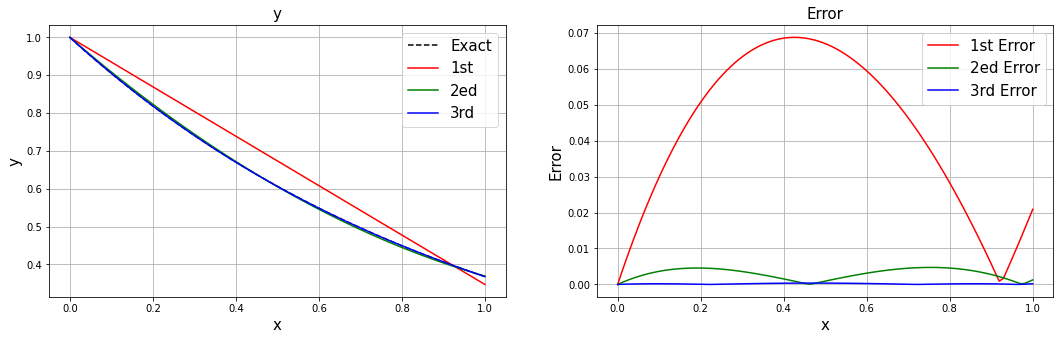

In [23]:
result_1(10000)

result 2
---
Error Graph

Poly + EC vs PINN

setting
---
train_x : 0 ~ 1 사이 20개 (균등 분배)

layer 개수 : 4개

weight : 32, 64, 64, 32

optimizer function : tanh

Poly weight 개수 : 3개

Poly Epoch : 10,000

Poly + EC, PINN Epoch : 1000, 10000

start y
iter : 0, y_loss : 1.555135726928711
iter : 1000, y_loss : 0.23617756366729736
iter : 2000, y_loss : 0.037251390516757965
iter : 3000, y_loss : 0.015614059753715992
iter : 4000, y_loss : 0.010285449214279652
iter : 5000, y_loss : 0.005297453608363867
iter : 6000, y_loss : 0.001791823306120932
iter : 7000, y_loss : 0.00030649156542494893
iter : 8000, y_loss : 2.0019026123918593e-05
iter : 9000, y_loss : 3.986881438322598e-06
start y + EC and PINN
iter : 0, yEC_loss : 0.06892586499452591
iter : 0, PINN_loss : 1.000885248184204
4/4 [==============================] - 0s 977us/step


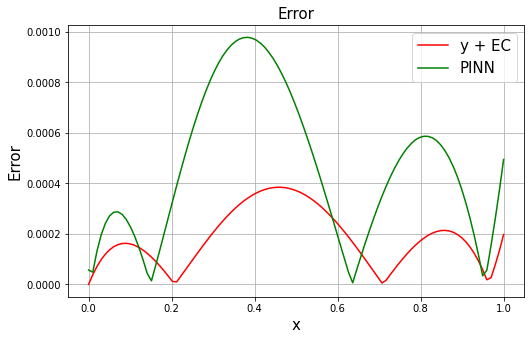

In [34]:
result_2(1000)

start y
iter : 0, loss_1 : 1.397039771080017
iter : 0, loss_2 : 12.629337310791016
iter : 0, loss_3 : 0.9116182327270508
iter : 5000, loss_1 : 0.036801327019929886
iter : 5000, loss_2 : 0.00688063632696867
iter : 5000, loss_3 : 0.00708813825622201
start y + EC and PINN
iter : 0, yEC_loss : 0.10223373025655746
iter : 0, yEC_loss : 1.180951714515686
iter : 0, yEC_loss : 0.11988667398691177
iter : 0, PINN_loss : 1.0061042308807373
iter : 5000, yEC_loss : 2.1341409137676237e-06
iter : 5000, yEC_loss : 5.105722721054917e-06
iter : 5000, yEC_loss : 3.2463351544720354e-06
iter : 5000, PINN_loss : 9.636691174819134e-06
4/4 [==============================] - 0s 977us/step


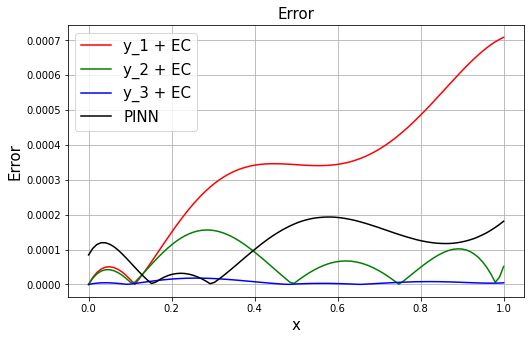

In [35]:
result_2(10000)